In [7]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics

In [8]:
from scipy.ndimage import convolve
from scipy.signal import convolve2d

class Connect4Game(object):
  def __init__(self):
    self.board = np.zeros((6, 7))
    self.tops = np.zeros(7)
    self.moves_played = 0
    self.pieces = {1: "|0|",
                   0: "|·|",
                   -1:"|O|"}
  def render(self):
    for row in reversed(range(6)):
      print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))
  def reset(self):
    self.board *= 0
    self.tops *= 0
    self.moves_played = 0
  def play(self, col, color):
    self.board[int(self.tops[col])][col] = color
    self.tops[col] += 1
    self.moves_played += 1
  def result(self):
    """ Returns 0 if it's a tie; returns None if the game is not over; returns -1 if player -1 wins, and 1 if player 1 wins."""
    if self.moves_played == 42: return 0
    kernel_row = [[1, 1, 1, 1]]
    kernel_col = [[1],
                  [1],
                  [1],
                  [1]]
    kernel_dia = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
    kernel_dia2 = [[0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0],
                  [1, 0, 0, 0]]
    for kernel in [np.array(kernel_row), np.array(kernel_col), np.array(kernel_dia), np.array(kernel_dia2)]:
      check = convolve2d(self.board, kernel, mode='same', boundary='fill', fillvalue=0)
      #print(check)
      if (check == 4).any(): return 1
      check2 = convolve2d(self.board, -kernel, mode='same', boundary='fill', fillvalue=0)
      if (check2 == 4).any(): return -1
    return None 


In [9]:
def human_play():
  game = Connect4Game()
  turn = 1
  while game.result() == None:
    game.render()
    game.play(int(input()), turn); turn *= -1
  print("Result: ", game.result())

In [10]:
import tqdm
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as kb

def create_Q_network(NUM_CONV_LAYERS = 6, describe = True):
    in_ = layers.Input((6, 7))
    X = layers.Reshape((6, 7, 1))(in_)
    for i in range(NUM_CONV_LAYERS-1):
        X_skip = layers.Conv2D(32, (4,4), activation = 'relu', padding = "same")(X)
        X_skip = layers.BatchNormalization()(X_skip)
        X_skip = layers.Conv2D(32, (2,2), activation = 'relu', padding = "same")(X_skip)
        X_skip = layers.BatchNormalization()(X_skip)
        X = layers.BatchNormalization()(X)
        X = layers.Add()([X_skip, X])
    X = layers.Conv2D(32, (3,3), activation = 'relu')(X)
    X = layers.BatchNormalization()(X)
    #X = layers.GlobalAveragePooling2D()(X)
    X = layers.Flatten()(X)
    #X = layers.Dense(256, activation = 'relu')(X)
    X = layers.Dense(7, activation = 'tanh')(X)
    model = models.Model(in_, X)
    if describe: 
        model.summary()
    return model

class TrainBuffer(object):
    def __init__(self, max_queue = 50000, clean_extra = 10000):
        self.X1 = []; self.X2 = []
        self.y = []; self.max_queue = max_queue
        self.clean_extra = clean_extra
    def push(self, X1, X2, y):
        self.X1.extend(X1)
        self.X2.extend(X2)
        self.y.extend(y)
        #if len(self.y) > self.max_queue: self.y = self.y[len(self.y) - self.max_queue:]
        if len(self.X1) > self.max_queue + self.clean_extra:
            idxs = np.random.choice(len(self.X1), size = self.max_queue, replace = False)
            tmp_X1 = [self.X1[idxs[i]] for i in range(self.max_queue)]
            tmp_X2 = [self.X2[idxs[i]] for i in range(self.max_queue)]
            tmp_y = [self.y[idxs[i]] for i in range(self.max_queue)]
            self.X1 = tmp_X1
            self.X2 = tmp_X2
            self.y = tmp_y
            


class DQLearner(object):
    def __init__(self):
        self.game = Connect4Game()
        self.model = create_Q_network()
        self.teacher = create_Q_network()
        self.teacher.set_weights(self.model.get_weights())
        self.e = 0.8
        self.buffer = TrainBuffer()
        self.train_every = 500

        def custom_loss(y_true, y_pred):
            # calculate loss, using y_pred
            return kb.sum(kb.square(kb.sum(y_true, axis = 1) - kb.sum(y_true * y_pred, axis = 1)))

        self.model.compile(loss = custom_loss, optimizer = optimizers.Adam(1e-4), metrics = ['acc', 'mse'])

    def norm_probs(self, probs):
        probs *= (self.game.tops != 6)
        probs *= (1 / np.sum(probs))
        return probs

    def run_game(self):
        states_p1, actions_p1, states_pneg1, actions_pneg1 = [], [], [], []
        turn = 1
        while (self.game.result() == None):
            state = self.game.board * turn
            if np.random.uniform() < self.e:
                probs = np.ones(7) / 7
                probs = self.norm_probs(probs)

                action = np.random.choice(range(0, 7), p = probs)
                self.game.play(action, turn)
            else:
                Q = self.teacher(state[np.newaxis,:,:]) + 0.0001
                qualia = Q.numpy()[0]
                qualia = self.norm_probs(qualia)

                action = np.argmax(qualia) # OLD AND WRONG np.random.choice(range(0, 7), p = probs)
                self.game.play(action, turn)
            if turn == 1: 
                states_p1.append(state)
                actions_p1.append(action)
            else: 
                states_pneg1.append(state)
                actions_pneg1.append(action)
            turn *= -1

        labels = []
        for i in actions_p1:
            label = np.zeros(7); label[i] = self.game.result()
            labels.append(label)

        self.buffer.push(states_p1, actions_p1, labels)

        labels = []
        for i in actions_pneg1:
            label = np.zeros(7); label[i] = -1 * self.game.result()
            labels.append(label)

        self.buffer.push(states_pneg1, actions_pneg1, labels)

        self.game.reset()

    def train(self, epochs = 1):
        for j in tqdm.trange(epochs):
            for i in range(self.train_every):
                self.run_game()
            self.model.fit(x = np.array(self.buffer.X1), y = np.array(self.buffer.y), batch_size = 128)

In [11]:
# Evaluate
import random

class Ladder(object):
    def __init__(self):
        self.game = Connect4Game()
    def play_match(self, player_1, player_neg1, render = False):
        turn = 1
        self.game.reset()
        while (self.game.result() == None):
            if render: self.game.render()

            state = self.game.board * turn
            if turn == 1:
                action = player_1.make_move(state, self.game.tops)
            if turn == -1:
                action = player_neg1.make_move(state, self.game.tops)
            self.game.play(action, turn)
            
            turn *= -1
            
        result = self.game.result()
        self.game.reset()
        return result
    
    def play_tournament(self, players, NUM_MATCHES = 1000, K = 16, onesd = 400):
        MMR = {}
        for player in players:
            MMR[player.name] = 1000
        for match in tqdm.trange(NUM_MATCHES):
            p1, p_neg1 = random.sample(players, 2)
            result = self.play_match(p1, p_neg1)
            
            SA = (result + 1) / 2 # A scores 1 point if win, 0 points if loss.
            SB = (-result + 1) / 2 # B scores 1 point if win, -1 points if loss.
            # Both score 0.5 points if tie.
            EA = 1 / (1 + 10**((MMR[p_neg1.name] - MMR[p1.name]) / onesd))
            EB = 1 / (1 + 10**((MMR[p1.name] - MMR[p_neg1.name]) / onesd))
            
            MMR[p1.name] = MMR[p1.name] + K * (SA - EA)
            MMR[p_neg1.name] = MMR[p_neg1.name] + K * (SB - EB)
        return MMR

In [12]:
# All a class needs to be a valid player is the method make_move(self, state, tops) and the attribute name.

class RLPlayer(object):
    def __init__(self, model, name):
        self.model = model; self.name = name
        self.DETERMINISTIC = False
    def norm_probs(self, probs, tops):
        probs *= (tops != 6)
        probs *= (1 / np.sum(probs))
        return probs
    def make_move(self, state, tops): # Tops is the top of each column in game, used for not making invalid moves
        Q = self.model(state[np.newaxis,:,:]) + 0.0001
        probs = Q.numpy()[0]
        probs = self.norm_probs(probs, tops)
        if not self.DETERMINISTIC: action = np.random.choice(range(0, 7), p = probs)
        else: action = np.argmax(probs)
        return action
    
class RandomPlayer(object):
    def __init__(self, name = "Random"):
        self.name = name
    def norm_probs(self, probs, tops):
        probs *= (tops != 6)
        probs *= (1 / np.sum(probs))
        return probs
    def make_move(self, state, tops):
        probs = np.ones(7) / 7
        probs = self.norm_probs(probs, tops)
        return np.random.choice(range(0, 7), p = probs)


In [13]:
agent = DQLearner()
agent.e = 0.4

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 6, 7, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 6, 7, 32)     544         ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 6, 7, 32)    128         ['conv2d[0][0]']                 
 alization)                                                                                   

                                                                                                  
 add_4 (Add)                    (None, 6, 7, 32)     0           ['batch_normalization_13[0][0]', 
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 4, 5, 32)     9248        ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_15 (BatchN  (None, 4, 5, 32)    128         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 flatten (Flatten)              (None, 640)          0           ['batch_normalization_15[0][0]'] 
          

                                                                                                  
 add_8 (Add)                    (None, 6, 7, 32)     0           ['batch_normalization_26[0][0]', 
                                                                  'batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 6, 7, 32)     16416       ['add_8[0][0]']                  
                                                                                                  
 batch_normalization_28 (BatchN  (None, 6, 7, 32)    128         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_20 (Conv2D)             (None, 6, 7, 32)     4128        ['batch_normalization_28[0][0]'] 
          

In [8]:
R = RandomPlayer()
players = [R]

for k in range(0,50):
    print("================Epoch "+str(k)+"==================")
    print("Epsilon:", agent.e)
    print("Games played:", k * 10 * agent.train_every)
    agent.train(epochs = 10)
    
    ladder = Ladder()
    P = RLPlayer(model = agent.model, name = "Epoch" + str(k))
    players.append(P)
    results = ladder.play_tournament(players, NUM_MATCHES = 500)
    print("================Ending Tournament Results=============")
    print(results)
    
    agent.model.save_weights(str(k) + "_v4.h5")
    agent.teacher.set_weights(agent.model.get_weights())
    agent.e *= 0.9 # Epsilon decay

================Epoch 0==================
Epsilon: 0.4
Games played: 0


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

76/76 [==============================] - 8s 83ms/step - loss: 30.8890 - acc: 0.1498 - mse: 0.9204


 10%|████████▏                                                                         | 1/10 [02:21<21:09, 141.04s/it]

150/150 [==============================] - 13s 84ms/step - loss: 0.9473 - acc: 0.1483 - mse: 1.0812


 20%|████████████████▍                                                                 | 2/10 [04:43<18:55, 141.96s/it]

226/226 [==============================] - 16s 73ms/step - loss: 0.1760 - acc: 0.1434 - mse: 1.1069


 30%|████████████████████████▌                                                         | 3/10 [07:18<17:14, 147.74s/it]

300/300 [==============================] - 25s 82ms/step - loss: 0.0481 - acc: 0.1493 - mse: 1.1172


 40%|████████████████████████████████▊                                                 | 4/10 [10:11<15:45, 157.62s/it]

375/375 [==============================] - 35s 92ms/step - loss: 0.0202 - acc: 0.1414 - mse: 1.1225


 50%|█████████████████████████████████████████                                         | 5/10 [12:47<13:05, 157.16s/it]

451/451 [==============================] - 39s 87ms/step - loss: 0.0129 - acc: 0.1388 - mse: 1.1256


 60%|█████████████████████████████████████████████████▏                                | 6/10 [16:08<11:28, 172.18s/it]

446/446 [==============================] - 33s 74ms/step - loss: 0.0064 - acc: 0.1421 - mse: 1.1281


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [18:54<08:29, 169.98s/it]

441/441 [==============================] - 36s 81ms/step - loss: 0.0032 - acc: 0.1396 - mse: 1.1294


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [21:30<05:31, 165.53s/it]

440/440 [==============================] - 36s 81ms/step - loss: 0.0030 - acc: 0.1409 - mse: 1.1303


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [24:24<02:48, 168.39s/it]

438/438 [==============================] - 36s 81ms/step - loss: 0.0029 - acc: 0.1406 - mse: 1.1314


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.08it/s]


================Ending Tournament Results=============
{'Random': 1030.2507631242092, 'Epoch0': 969.7492368757897}
================Epoch 1==================
Epsilon: 0.36000000000000004
Games played: 5000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

434/434 [==============================] - 34s 78ms/step - loss: 0.0012 - acc: 0.1764 - mse: 1.1322


 10%|████████▏                                                                         | 1/10 [02:42<24:22, 162.46s/it]

429/429 [==============================] - 37s 86ms/step - loss: 9.2460e-04 - acc: 0.2015 - mse: 1.1323


 20%|████████████████▍                                                                 | 2/10 [05:40<22:52, 171.58s/it]

424/424 [==============================] - 32s 74ms/step - loss: 7.5945e-04 - acc: 0.2164 - mse: 1.1327


 30%|████████████████████████▌                                                         | 3/10 [08:23<19:33, 167.67s/it]

419/419 [==============================] - 35s 83ms/step - loss: 6.1619e-04 - acc: 0.2300 - mse: 1.1316


 40%|████████████████████████████████▊                                                 | 4/10 [11:13<16:51, 168.65s/it]

415/415 [==============================] - 31s 75ms/step - loss: 4.2813e-04 - acc: 0.2398 - mse: 1.1312


 50%|█████████████████████████████████████████                                         | 5/10 [14:11<14:19, 171.93s/it]

414/414 [==============================] - 31s 74ms/step - loss: 4.7959e-04 - acc: 0.2487 - mse: 1.1307


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:00<11:23, 170.86s/it]

410/410 [==============================] - 31s 76ms/step - loss: 3.3073e-04 - acc: 0.2599 - mse: 1.1319


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [19:42<08:24, 168.13s/it]

407/407 [==============================] - 34s 83ms/step - loss: 1.9520e-04 - acc: 0.2661 - mse: 1.1318


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [22:43<05:44, 172.28s/it]

404/404 [==============================] - 33s 82ms/step - loss: 1.7402e-04 - acc: 0.2708 - mse: 1.1322


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [25:48<02:56, 176.27s/it]

402/402 [==============================] - 36s 89ms/step - loss: 1.3919e-04 - acc: 0.2771 - mse: 1.1316


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


================Ending Tournament Results=============
{'Random': 1047.9169976447688, 'Epoch0': 993.8912695206524, 'Epoch1': 958.1917328345803}
================Epoch 2==================
Epsilon: 0.32400000000000007
Games played: 10000


  0%|                                                                                           | 0/10 [00:45<?, ?it/s]


KeyboardInterrupt: 

In [78]:
ladder = Ladder()
P = RLPlayer(model = agent.model, name = "Epoch" + str(k))
players.append(P)
results = ladder.play_tournament(players, NUM_MATCHES = 500)
print("================Ending Tournament Results=============")
print(results)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:40<00:00,  3.12it/s]

================Ending Tournament Results=============
{'Random': 1000.5301290074517, 'Epoch0': 999.4698709925477}


In [40]:
agent.model.output_shape

(None, 7)

In [39]:
np.array(agent.buffer.y).shape

(5081, 7)

In [49]:
preds = agent.model(np.array(agent.buffer.X1))

In [65]:
np.sum(preds * np.array(agent.buffer.y), axis = 1)

(5081,)

In [69]:
agent.model.fit(x = np.array(agent.buffer.X1), y = np.array(agent.buffer.y), batch_size = 128)

40/40 [==============================] - 5s 76ms/step - loss: 127.4961 - acc: 0.1301


In [15]:
WEIGHT_PATH = "15_v3"
agent = DQLearner()
if WEIGHT_PATH != None:
    agent.model.load_weights(WEIGHT_PATH)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 6, 7, 1)      0           ['input_3[0][0]']                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 6, 7, 32)     544         ['reshape_2[0][0]']              
                                                                                                  
 batch_normalization_32 (BatchN  (None, 6, 7, 32)    128         ['conv2d_22[0][0]']              
 ormalization)                                                                              

                                                                                                  
 add_14 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_45[0][0]', 
                                                                  'batch_normalization_46[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 5, 32)     9248        ['add_14[0][0]']                 
                                                                                                  
 batch_normalization_47 (BatchN  (None, 4, 5, 32)    128         ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 flatten_2 (Flatten)            (None, 640)          0           ['batch_normalization_47[0][0]'] 
          

                                                                                                  
 add_18 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_58[0][0]', 
                                                                  'batch_normalization_59[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 6, 7, 32)     16416       ['add_18[0][0]']                 
                                                                                                  
 batch_normalization_60 (BatchN  (None, 6, 7, 32)    128         ['conv2d_41[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_42 (Conv2D)             (None, 6, 7, 32)     4128        ['batch_normalization_60[0][0]'] 
          

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for 15_v3

In [36]:
"""
new_buffer = TrainBuffer()
new_buffer.X1 = agent.buffer.X1
new_buffer.X2 = agent.buffer.X2
new_buffer.y = agent.buffer.y
"""

In [16]:
turn = 1
DETERMINISTIC = True
agent.game.reset()
while (agent.game.result() == None):
    agent.game.render()
    if turn == -1:
        state = agent.game.board * turn
        Q = agent.model(state[np.newaxis,:,:]) + 0.0001
        probs = Q.numpy()[0]
        print(probs)
        probs = agent.norm_probs(probs)
        if not DETERMINISTIC: action = np.random.choice(range(0, 7), p = probs)
        else: action = np.argmax(probs)
        agent.game.play(action, turn)
    else:
        agent.game.play(int(input()), turn)
    turn *= -1
agent.game.reset()

C:\Users\william\AppData\Local\Temp\ipykernel_58104\2579177039.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))


|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
5
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||0||·|
[ 0.03524405  0.06657165 -0.06360156  0.10585309  0.06583107  0.03936383
 -0.07308757]
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||O||·||0||·|


KeyboardInterrupt: Interrupted by user

In [15]:
agent.buffer.y[:20]

[array([ 0.,  0., -1.,  0.,  0.,  0.,  0.]),
 array([0., 0., 0., 1., 0., 0., 0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0., -1.]),
 array([0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1.]),
 array([-1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0., 0., 0., 0., 0., 0., 1.]),
 array([-1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0., 0., 0., 0., 1., 0., 0.]),
 array([ 0.,  0.,  0., -1.,  0.,  0.,  0.]),
 array([ 0., -1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0., -1.]),
 array([0., 0., 0., 0., 1., 0., 0.]),
 array([ 0.,  0., -1.,  0.,  0.,  0.,  0.]),
 array([1., 0., 0., 0., 0., 0., 0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0., -1.]),
 array([ 0.,  0.,  0.,  0.,  0., -1.,  0.]),
 array([0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0., -1.])]

In [11]:
agent.buffer.X1[0]

array([[-1.,  1., -1., -1., -1.,  0.,  1.],
       [-1.,  0.,  0., -0.,  1., -0., -1.],
       [-0., -0.,  0., -0.,  0.,  0.,  1.],
       [-0., -0., -0., -0., -0., -0.,  1.],
       [-0., -0.,  0., -0., -0., -0.,  0.],
       [-0., -0.,  0., -0.,  0., -0.,  0.]])

In [13]:
agent.model(np.array(agent.buffer.X1[0])[np.newaxis, :, :])

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.9989412 , 0.99979913, 0.99989206, 0.9901459 , 0.9999187 ,
        0.9975302 , 0.9999171 ]], dtype=float32)>

In [ ]:
agent.model.save_weights("0.75_v2.h5")

In [13]:
agent.e = 0.1

In [49]:
import os
players = []
for i in os.listdir():
    if 'v3.h5' in i:
        M = create_Q_network(describe = False)
        M.load_weights(i)
        P = RLPlayer(model = M, name = i[:-3])
        players.append(P)
random = RandomPlayer()
players.append(random)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape_5 (Reshape)            (None, 6, 7, 1)      0           ['input_6[0][0]']                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 6, 7, 32)     544         ['reshape_5[0][0]']              
                                                                                                  
 batch_normalization_80 (BatchN  (None, 6, 7, 32)    128         ['conv2d_55[0][0]']              
 ormalization)                                                                              

                                                                                                  
 add_29 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_93[0][0]', 
                                                                  'batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 4, 5, 32)     9248        ['add_29[0][0]']                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 4, 5, 32)    128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 flatten_5 (Flatten)            (None, 640)          0           ['batch_normalization_95[0][0]'] 
          

                                                                                                  
 add_33 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_106[0][0]',
                                                                  'batch_normalization_107[0][0]']
                                                                                                  
 conv2d_74 (Conv2D)             (None, 6, 7, 32)     16416       ['add_33[0][0]']                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 6, 7, 32)    128         ['conv2d_74[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_75 (Conv2D)             (None, 6, 7, 32)     9248        ['batch_normalization_108[0][0]']
          

                                                                                                  
 add_37 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_119[0][0]',
                                                                  'batch_normalization_120[0][0]']
                                                                                                  
 conv2d_83 (Conv2D)             (None, 6, 7, 32)     16416       ['add_37[0][0]']                 
                                                                                                  
 batch_normalization_121 (Batch  (None, 6, 7, 32)    128         ['conv2d_83[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_84 (Conv2D)             (None, 6, 7, 32)     9248        ['batch_normalization_121[0][0]']
          

                                                                                                  
 add_41 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_132[0][0]',
                                                                  'batch_normalization_133[0][0]']
                                                                                                  
 conv2d_92 (Conv2D)             (None, 6, 7, 32)     16416       ['add_41[0][0]']                 
                                                                                                  
 batch_normalization_134 (Batch  (None, 6, 7, 32)    128         ['conv2d_92[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_93 (Conv2D)             (None, 6, 7, 32)     9248        ['batch_normalization_134[0][0]']
          

                                                                                                  
 add_45 (Add)                   (None, 6, 7, 32)     0           ['batch_normalization_145[0][0]',
                                                                  'batch_normalization_146[0][0]']
                                                                                                  
 conv2d_101 (Conv2D)            (None, 6, 7, 32)     16416       ['add_45[0][0]']                 
                                                                                                  
 batch_normalization_147 (Batch  (None, 6, 7, 32)    128         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_102 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_147[0][0]']
          

 input_11 (InputLayer)          [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape_10 (Reshape)           (None, 6, 7, 1)      0           ['input_11[0][0]']               
                                                                                                  
 conv2d_110 (Conv2D)            (None, 6, 7, 32)     544         ['reshape_10[0][0]']             
                                                                                                  
 batch_normalization_160 (Batch  (None, 6, 7, 32)    128         ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_111 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_160[0][0]']
          

                                                                                                  
 conv2d_120 (Conv2D)            (None, 4, 5, 32)     9248        ['add_54[0][0]']                 
                                                                                                  
 batch_normalization_175 (Batch  (None, 4, 5, 32)    128         ['conv2d_120[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 flatten_10 (Flatten)           (None, 640)          0           ['batch_normalization_175[0][0]']
                                                                                                  
 dense_10 (Dense)               (None, 7)            4487        ['flatten_10[0][0]']             
                                                                                                  
Total para

                                                                                                  
 conv2d_129 (Conv2D)            (None, 6, 7, 32)     16416       ['add_58[0][0]']                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 6, 7, 32)    128         ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_130 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_188[0][0]']
                                                                                                  
 batch_normalization_189 (Batch  (None, 6, 7, 32)    128         ['conv2d_130[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_138 (Conv2D)            (None, 6, 7, 32)     16416       ['add_62[0][0]']                 
                                                                                                  
 batch_normalization_201 (Batch  (None, 6, 7, 32)    128         ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_139 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_201[0][0]']
                                                                                                  
 batch_normalization_202 (Batch  (None, 6, 7, 32)    128         ['conv2d_139[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_147 (Conv2D)            (None, 6, 7, 32)     16416       ['add_66[0][0]']                 
                                                                                                  
 batch_normalization_214 (Batch  (None, 6, 7, 32)    128         ['conv2d_147[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_148 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_214[0][0]']
                                                                                                  
 batch_normalization_215 (Batch  (None, 6, 7, 32)    128         ['conv2d_148[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_156 (Conv2D)            (None, 6, 7, 32)     16416       ['add_70[0][0]']                 
                                                                                                  
 batch_normalization_227 (Batch  (None, 6, 7, 32)    128         ['conv2d_156[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_157 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_227[0][0]']
                                                                                                  
 batch_normalization_228 (Batch  (None, 6, 7, 32)    128         ['conv2d_157[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_165 (Conv2D)            (None, 6, 7, 32)     544         ['reshape_15[0][0]']             
                                                                                                  
 batch_normalization_240 (Batch  (None, 6, 7, 32)    128         ['conv2d_165[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_166 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_240[0][0]']
                                                                                                  
 batch_normalization_241 (Batch  (None, 6, 7, 32)    128         ['conv2d_166[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_255 (Batch  (None, 4, 5, 32)    128         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 flatten_15 (Flatten)           (None, 640)          0           ['batch_normalization_255[0][0]']
                                                                                                  
 dense_15 (Dense)               (None, 7)            4487        ['flatten_15[0][0]']             
                                                                                                  
Total params: 128,107
Trainable params: 127,145
Non-trainable params: 962
__________________________________________________________________________________________________
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)    

 batch_normalization_268 (Batch  (None, 6, 7, 32)    128         ['conv2d_184[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_185 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_268[0][0]']
                                                                                                  
 batch_normalization_269 (Batch  (None, 6, 7, 32)    128         ['conv2d_185[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_270 (Batch  (None, 6, 7, 32)    128         ['add_83[0][0]']                 
 Normalization)                                                                                   
          

 batch_normalization_281 (Batch  (None, 6, 7, 32)    128         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_194 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_281[0][0]']
                                                                                                  
 batch_normalization_282 (Batch  (None, 6, 7, 32)    128         ['conv2d_194[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_283 (Batch  (None, 6, 7, 32)    128         ['add_87[0][0]']                 
 Normalization)                                                                                   
          

 batch_normalization_294 (Batch  (None, 6, 7, 32)    128         ['conv2d_202[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_203 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_294[0][0]']
                                                                                                  
 batch_normalization_295 (Batch  (None, 6, 7, 32)    128         ['conv2d_203[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_296 (Batch  (None, 6, 7, 32)    128         ['add_91[0][0]']                 
 Normalization)                                                                                   
          

 batch_normalization_307 (Batch  (None, 6, 7, 32)    128         ['conv2d_211[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_212 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_307[0][0]']
                                                                                                  
 batch_normalization_308 (Batch  (None, 6, 7, 32)    128         ['conv2d_212[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_309 (Batch  (None, 6, 7, 32)    128         ['add_95[0][0]']                 
 Normalization)                                                                                   
          

 batch_normalization_320 (Batch  (None, 6, 7, 32)    128         ['conv2d_220[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_221 (Conv2D)            (None, 6, 7, 32)     9248        ['batch_normalization_320[0][0]']
                                                                                                  
 batch_normalization_321 (Batch  (None, 6, 7, 32)    128         ['conv2d_221[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_322 (Batch  (None, 6, 7, 1)     4           ['reshape_20[0][0]']             
 Normalization)                                                                                   
          

 flatten_20 (Flatten)           (None, 640)          0           ['batch_normalization_335[0][0]']
                                                                                                  
 dense_20 (Dense)               (None, 7)            4487        ['flatten_20[0][0]']             
                                                                                                  
Total params: 128,107
Trainable params: 127,145
Non-trainable params: 962
__________________________________________________________________________________________________


In [57]:
for player in players:
    print(player.name)

0_v3
10_v3
11_v3
12_v3
13_v3
14_v3
15_v3
1_v3
2_v3
3_v3
4_v3
5_v3
6_v3
7_v3
8_v3
9_v3
Random


In [83]:
for player in players:
    player.DETERMINISTIC = True

In [84]:
results = ladder.play_tournament(players, NUM_MATCHES = 5000)

 61%|███████████████████████████████████████████████▎                              | 3030/5000 [23:07<15:02,  2.18it/s]


KeyboardInterrupt: 

In [ ]:
{k: v for k, v in sorted(results.items(), key=lambda item: item[1])}

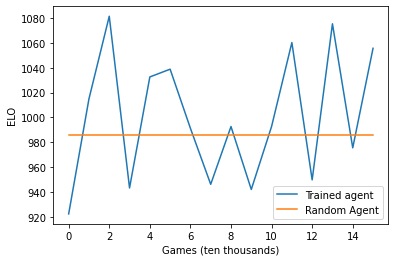

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.lineplot(x = range(16), y = [results[str(i)+'_v3'] for i in range(16)], label = "Trained agent")
ax.set(xlabel = "Games (ten thousands)", ylabel = "ELO")
sns.lineplot(x = range(16), y = [results["Random"] for i in range(16)], label = "Random Agent")
plt.show()

In [54]:
agent.model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(1e-3), metrics = ['acc'])
agent.model.fit(x = np.array(agent.buffer.X1), y = np.array(agent.buffer.y), batch_size = 128, epochs = 20)

In [56]:
agent.model.predict(np.array(agent.buffer.X1[:1]))

1/1 [==============================] - 0s 271ms/step


array([[0.14310563, 0.11959383, 0.16705386, 0.14911424, 0.15166679,
        0.13860933, 0.1308563 ]], dtype=float32)

In [47]:
agent.buffer.y[0]

array([0., 1., 0., 0., 0., 0., 0.])